# Quantum Kernel Machine Learning

In this notebook, we present a staged comparison between standard SVM kernels and a Quantum version in which a Quantum kernel is used to classify data that is difficult to classify with a standard approach.

We use `qiskit` to calculate a kernel matrix using a quantum feature map, then use this kernel matrix in `scikit-learn` classification and clustering algorithms.


In [ ]:
# Load some libraries
import matplotlib.pyplot as plt
import numpy as np

from sklearn.svm import SVC
from sklearn.cluster import SpectralClustering
from sklearn.metrics import normalized_mutual_info_score

from qiskit import BasicAer
from qiskit.algorithms.state_fidelities import ComputeUncompute
from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import Sampler
from qiskit.utils import algorithm_globals
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.datasets import ad_hoc_data

seed = 12345
algorithm_globals.random_seed = seed

## Standard Support Vector Machines (SVMs)

Support Vector Machines have been around for a while but remain a popular machine learning technique, despite having to compete with e.g. Deep Learning.  They are often used for datasets that are too small to allow Deep Neural Networks to be trained properly.

In their simplest, binary task form, SVMs work by searching for a __linear separating plane__ that maximises the distance between the decision surface and the closest examples from both classes.  (See the image borrowed from Wikipedia below.)

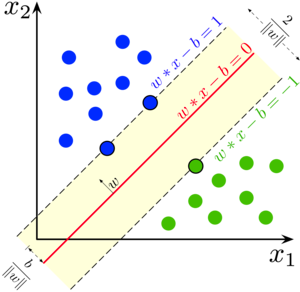

When two datasets are not linearly separable, SVMs can use kernels to implicitly map the data into a high dimensional representation, where finding a linear separating plane is more likely.  A kernel 

> $k(\vec{x}_i, \vec{x}_j) = \langle f(\vec{x}_i), f(\vec{x}_j) \rangle$

represents an easy-to-compute version of the dot-product between the mapped version (using the mapping function $f$) of two vectors to some (possibly hard compute) high dimensional space. Popular kernels include the polynomial kernel. 

> $k(\vec{x}_i, \vec{x}_j) = \langle \vec{x}_i,\vec{x}_j \rangle^d$ 

which allows the SVM to learn polynomial decision boundaries instead of only linear and the Radial Basis Kernel 

> $k(\vec{x}_i, \vec{x}_j) = exp(-\gamma |\vec{x}_i - \vec{x}_j|^2)$ 

which actually represents the dot product in a theoretically infinitely dimensional space.

### Normal Data

The first data we will consider is pretty normal data.  It is about dogs, and as everybody with a heart knows, dogs are pretty well behaved.  Running the code below shows the two dimensional data on a plot.

In [ ]:
from dataclasses import dataclass

@dataclass
class DogDataset:
    """ This class define a distribution of dogs in a kennel. A dog will be 
    considered happy if he is in certain range from the water.
    """
    water_position: np.array         # Position of the water
    happy_distance: float             # Distance from the water for a dog to be happy
    dog_positions: np.array          # Position of the dog in the kennel

    @property
    def number_of_dogs(self) -> int:
        return self.dog_positions.shape[0]
        
    @property
    def dog_distances_from_the_water(self) -> np.array:
        """ An array of float with the minimal cartesian distance to water"""
        if self.water_position.ndim == 1:
            return np.sqrt(np.sum((self.dog_positions - self.water_position)**2, axis=1))
        else:
            return np.min([
                np.sqrt(np.sum((self.dog_positions - water_position)**2, axis=1))
                for water_position in self.water_position], axis=0)

    @property
    def happy_dogs(self) -> np.array:
        """ True/False array of the happy dogs"""
        return self.dog_distances_from_the_water <= self.happy_distance

    @property
    def sad_dogs(self) -> np.array:
        """ True/False array of the sad dogs"""
        return ~self.happy_dogs

    @property
    def features(self):
        """ Feature set of the dataset --> The position of the dogs"""
        return self.dog_positions

    @property
    def labels(self):
        """ Labels of the dataset --> 0 == happy, 1 == sad"""
        # All dogs are sad
        labels = np.full(self.number_of_dogs, fill_value=1)
        # Set the happy dogs to 0
        labels[self.happy_dogs] = 0
        return labels

def dog_plot(ds: DogDataset, figsize=(5,5), predictions=None):
    ffig, ax = plt.subplots(figsize=figsize)
    
    xpos = ds.dog_positions[:, 0]
    ypos = ds.dog_positions[:, 1]

    happy = ds.happy_dogs
    sad = ds.sad_dogs
    
    ax.scatter(
        xpos[happy],
        ypos[happy],
        marker="s",
        facecolors="w",
        edgecolors="b",
        label="Happy",
    )
    ax.scatter(
        xpos[sad],
        ypos[sad],
        marker="o",
        facecolors="w",
        edgecolors="r",
        label="Sad",
    )
    ax.scatter(
        ds.water_position[..., 0],
        ds.water_position[..., 1],
        marker="o",
        s=100,
        facecolors="blue",
        edgecolors="blue",
        label="Water",
    )
    
    if predictions is not None:
        wrong_predictions = self.labels != predictions
        ax.scatter(
            xpos[wrong_predictions],
            ypos[wrong_predictions],
            marker="x",
            c="red",
            s=60,
            label="Wrong prediction",
        )
    
    ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
    ax.set_title("Dog Data for Classification")

# Optimisation could be made by using functools.cache_property, but that also render the object immutable

def create_dog_train_and_test_uniform(
    train_size = 100,           # number of dogs in the train set
    test_size = 200,            # number of dogs in the test set
    water = [0, 1],             # Position (x, y) of the water (can be a list of position)
    happy_distance = 1.0,       # Distance from water for a dog the be happy
    kennel_dimension = [2, 2]   # Dimension (x, y) of the kennel
): 
    dog_train = DogDataset(
        dog_positions = np.random.uniform(0, kennel_dimension, (train_size, 2)),
        water_position = np.array(water, ndmin=3),
        happy_distance = happy_distance)
    dog_test = DogDataset(
        dog_positions = np.random.uniform(0, kennel_dimension, (test_size, 2)),
        water_position = np.array(water, ndmin=3),
        happy_distance = happy_distance)
    return dog_train, dog_test

dog_train, dog_test = create_dog_train_and_test_uniform(
    train_size = 100,
    test_size = 50,
    water = (0, 1),
    happy_distance = 1.0,
)

dog_plot(dog_train)
dog_plot(dog_test)




### Standard Kernel SVM performance

The code below builds, trains and tests a standard SVM, with a linear kernel.  Depending on your luck with the data generation, you will notice that a linear decision boundary might not always be sufficient to separate the happy from the sad dogs.  You might have more luck with a "poly" kernel or an "rbf" kernel (values you can fill in below), but while they do a pretty good job, they don't always help distinguish perfectly between our two kinds of best friends.

In [ ]:
def train_dog_svm(dog_train_dataset: DogDataset, kernel="linear"):
    svm = SVC(kernel=kernel)
    svm.fit(dog_train_dataset.features, dog_train_dataset.labels)
    return svm

dog_svm = train_dog_svm(dog_train, kernel="linear")

dog_score = dog_svm.score(dog_train.features, dog_train.labels)
print(f"Callable kernel classification test score: {dog_score}")

### Quantum Kernels

In quantum kernel machine learning, a quantum feature map $\phi(\vec{x})$ is used to map a classical feature vector $\vec{x}$ to a quantum Hilbert space, $| \phi(\vec{x})\rangle \langle \phi(\vec{x})|$, such that $K_{ij} = \left| \langle \phi^\dagger(\vec{x}_j)| \phi(\vec{x}_i) \rangle \right|^{2}$. See [_Supervised learning with quantum enhanced feature spaces_](https://arxiv.org/pdf/1804.11326.pdf) for more details.


### Less Normal Data

For our classification example, we will use the _ad hoc dataset_ as described in [_Supervised learning with quantum enhanced feature spaces_](https://arxiv.org/pdf/1804.11326.pdf), and the `scikit-learn` [support vector machine](https://scikit-learn.org/stable/modules/svm.html) classification (`svc`) algorithm. 

You can think of this data as cat data, as everyone with a brain knows, cats are evil and thus much harder to predict.  It is therefor also no surprise that Schrödinger chose a cat to be killed (maybe?) in a box.  Running the code below will show the cat learning data.

With our training and testing datasets ready, we set up the `FidelityQuantumKernel` class to calculate a kernel matrix using the [ZZFeatureMap](https://qiskit.org/documentation/stubs/qiskit.circuit.library.ZZFeatureMap.html). We use the reference implementation of the `Sampler` primitive and the `ComputeUncompute` fidelity that computes overlaps between states. These are the default values and if you don't pass a `Sampler` or `Fidelity` instance, the same objects will be created automatically for you.

In [ ]:
feature_map = ZZFeatureMap(feature_dimension=2, reps=2, entanglement="linear")
sampler = Sampler()
fidelity = ComputeUncompute(sampler=sampler)
kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)

The `scikit-learn` `SVC` algorithm allows us to define a [custom kernel](https://scikit-learn.org/stable/modules/svm.html#custom-kernels) in two ways: by providing the kernel as a callable function or by precomputing the kernel matrix. We can do either of these using the `FidelityQuantumKernel` class in `qiskit`.

The following code gives the kernel as a callable function:

In [ ]:
qsvc = SVC(kernel=kernel.evaluate)
qsvc.fit(dog_train.features, dog_train.labels)
score = qsvc.score(dog_train.features, dog_train.labels)

print(f"Callable kernel classification test score: {score}")

The following code precomputes and plots the training and testing kernel matrices before providing them to the `scikit-learn` `svc` algorithm:

In [ ]:
matrix_train = kernel.evaluate(x_vec=dog_train.features)
matrix_test = kernel.evaluate(x_vec=dog_test.features, y_vec=dog_train.features)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(
    np.asmatrix(matrix_train), interpolation="nearest", origin="upper", cmap="Blues"
)
axs[0].set_title("Ad hoc training kernel matrix")
axs[1].imshow(np.asmatrix(matrix_test), interpolation="nearest", origin="upper", cmap="Reds")
axs[1].set_title("Ad hoc testing kernel matrix")
plt.show()

svc = SVC(kernel="precomputed")
svc.fit(matrix_train, dog_train.labels)
score = svc.score(matrix_test, dog_test.labels)

print(f"Precomputed kernel classification test score: {score}")